In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn import metrics

from mlxtend.plotting import plot_decision_regions
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression


import warnings
import numpy as np
from collections import OrderedDict

from lob_data_utils import lob, db_result
from lob_data_utils.svm_calculation import lob_svm


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [2]:
data_length = 15000
stocks = ['9064', '9061', '9265']

In [3]:
d_stocks = {}
d_cv_stocks = {}
d_test_stocks = {}
for s in stocks:
    d, d_cv, d_test = lob.load_prepared_data(
        s, data_dir='../queue_imbalance/data/prepared', cv=True, length=data_length)
    d.index = pd.to_datetime(d['Unnamed: 0'].values)
    d_cv.index = pd.to_datetime(d_cv['Unnamed: 0'].values)
    d_test.index = pd.to_datetime(d_test['Unnamed: 0'].values)
    d_stocks[s] = d
    d_cv_stocks[s] = d_cv
    d_test_stocks[s] = d_test

In [4]:
d_stocks['9061'].head()

,Unnamed: 0,bid,ask,bid_price,ask_price,mid_price,sum_sell_ask,sum_buy_bid,mid_price_indicator,queue_imbalance
2013-09-13 10:36:00,2013-09-13 10:36:00,"[(550.0, 6364.0), (615.0, 2514.0), (630.0, 151...","[(699.2, 4945.0), (699.3, 15580.0), (699.4, 21...",699.0,699.2,699.10,4945.0,11521.0,1.0,0.399368
2013-09-13 10:37:00,2013-09-13 10:37:00,"[(550.0, 6364.0), (615.0, 2514.0), (630.0, 151...","[(699.3, 9528.0), (699.4, 17958.0), (699.5, 28...",699.1,699.3,699.20,9528.0,3722.0,1.0,-0.438189
2013-09-13 10:39:00,2013-09-13 10:39:00,"[(550.0, 6364.0), (615.0, 2514.0), (630.0, 151...","[(699.5, 3954.0), (699.6, 10269.0), (699.7, 16...",699.4,699.5,699.45,3954.0,4580.0,0.0,0.073354
2013-09-13 10:40:00,2013-09-13 10:40:00,"[(550.0, 6364.0), (615.0, 2514.0), (630.0, 151...","[(699.5, 3724.0), (699.6, 11982.0), (699.7, 16...",699.3,699.5,699.40,3724.0,8567.0,1.0,0.394028
2013-09-13 10:41:00,2013-09-13 10:41:00,"[(550.0, 6364.0), (615.0, 2514.0), (630.0, 151...","[(699.6, 458.0), (699.7, 13014.0), (699.8, 334...",699.5,699.6,699.55,458.0,3667.0,0.0,0.777939


## SVM

In [5]:
df_res = {}
for s in stocks:
    df_res_temp = pd.read_csv('res_svm_{}_15000.csv'.format(s))
    df_res_temp['stock'] = [s for i in range(len(df_res_temp))]
    df_res[s] = df_res_temp
df_res['9061'].head()

,Unnamed: 0,Unnamed: 0.1,svm,c,gamma,coef0,roc_cv_score,roc_train_score,stock
0,0,0,sigmoid,0.0005,0.0005,0.0000,0.5,0.5,9061
1,1,1,sigmoid,0.0005,0.0005,0.0005,0.5,0.5,9061
2,2,2,sigmoid,0.0005,0.0005,0.0050,0.5,0.5,9061
3,3,3,sigmoid,0.0005,0.0005,1.0000,0.5,0.5,9061
4,4,4,sigmoid,0.0005,0.0005,5.0000,0.5,0.5,9061


In [6]:
df_res['9061'].sort_values(by='roc_cv_score', ascending=False).head()

,Unnamed: 0,Unnamed: 0.1,svm,c,gamma,coef0,roc_cv_score,roc_train_score,stock
91,91,91,sigmoid,0.005,5.0000,0.0000,0.556986,0.546752,9061
92,92,92,sigmoid,0.005,5.0000,0.0005,0.556986,0.546644,9061
392,392,392,rbf,1000.000,0.0005,NaN,0.556970,0.546535,9061
93,93,93,sigmoid,0.005,5.0000,0.0050,0.555960,0.546767,9061
268,268,268,sigmoid,50.000,0.0050,1.0000,0.555505,0.544928,9061


In [7]:
df_best_svm = pd.DataFrame()
for s in stocks:
    idx_max = df_res[s]['roc_cv_score'].idxmax()
    df_best_svm = df_best_svm.append(df_res[s].loc[idx_max])
df_best_svm

,Unnamed: 0,Unnamed: 0.1,c,coef0,gamma,roc_cv_score,roc_train_score,stock,svm
227,227.0,227.0,5.000,NaN,5.000,0.542943,0.544917,9064,rbf
91,91.0,91.0,0.005,0.0,5.000,0.556986,0.546752,9061,sigmoid
268,268.0,268.0,50.000,1.0,0.005,0.555257,0.551880,9265,sigmoid


In [8]:
def fit_best_svm_classifier(df_best_svm, df, stock=None):
    gamma = df_best_svm[df_best_svm['stock'] == stock]['gamma'].values[0]
    coef0 = df_best_svm[df_best_svm['stock'] == stock]['coef0'].values[0]
    c = df_best_svm[df_best_svm['stock'] == stock]['c'].values[0]
    kernel = df_best_svm[df_best_svm['stock'] == stock]['svm'].values[0]

    X = df['queue_imbalance'].values.reshape(-1, 1)
    y = df['mid_price_indicator']
    
    clf = SVC(gamma=gamma, C=c, coef0=coef0, kernel=kernel)
    clf.fit(X, y)
    return clf
    

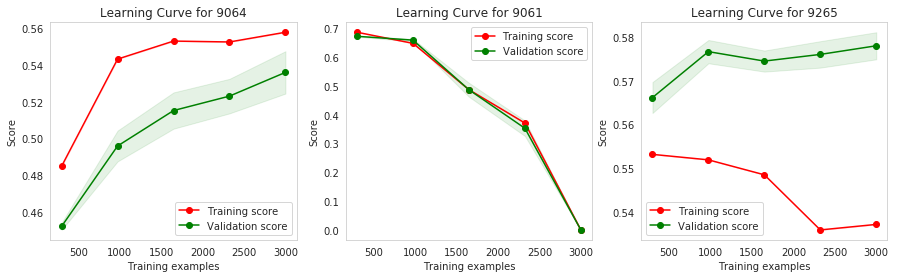

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import TimeSeriesSplit

f, ax = plt.subplots(1, 3, figsize=(15,4))
i = 0
for stock in stocks:
    log_clf = fit_best_svm_classifier(df_best_svm, d_stocks[stock], stock=stock)
    lob.plot_learning_curve(
        log_clf, d_stocks[stock]['queue_imbalance'].values.reshape(-1, 1),
        d_stocks[stock]['mid_price_indicator'], 
        cv=TimeSeriesSplit(n_splits=2, max_train_size=9000), ax=ax[i], scoring='f1')
    ax[i].set_title('Learning Curve for {}'.format(stock))
    i += 1
plt.savefig('svm_learning_curves.png')

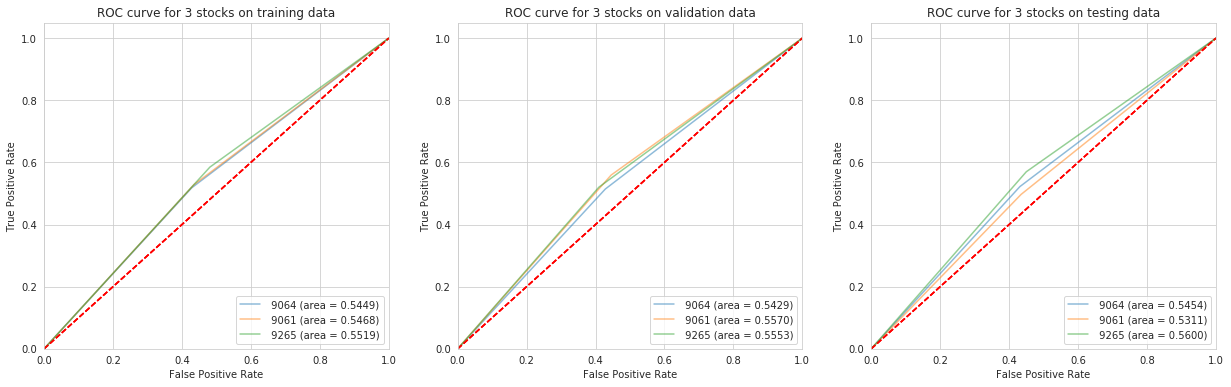

In [10]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21,6))
for stock in stocks:
    log_clf = fit_best_svm_classifier(df_best_svm, d_stocks[stock], stock=stock)
    pred_train = log_clf.predict(d_stocks[stock]['queue_imbalance'].values.reshape(-1, 1))
    pred_cv = log_clf.predict(d_cv_stocks[stock]['queue_imbalance'].values.reshape(-1, 1))
    pred_test = log_clf.predict(d_test_stocks[stock]['queue_imbalance'].values.reshape(-1, 1))
    d_stocks[stock]['pred_log'] = pred_train
    d_cv_stocks[stock]['pred_log'] = pred_cv
    d_test_stocks[stock]['pred_log'] = pred_test
    lob.plot_roc(d_stocks[stock], log_clf, stock=stock, label='', alpha=0.5, linestyle='-', ax=ax1,
                 title='ROC curve for 3 stocks on training data')
    lob.plot_roc(d_cv_stocks[stock], log_clf, stock=stock, label='', alpha=0.5, linestyle='-', ax=ax2,
                 title='ROC curve for 3 stocks on validation data')
    lob.plot_roc(d_test_stocks[stock], log_clf, stock=stock, label='', alpha=0.5, linestyle='-', ax=ax3,
                 title='ROC curve for 3 stocks on testing data')
    plt.savefig('svm_results.png')

In [11]:
def get_scores_dict_for_data(functions_to_run, dfs, log_clf, stock):
    scores = {'stock': stock}
    for func_name, func in functions_to_run.items():
        for df_name, df in dfs.items():
            pred = log_clf.predict(df['queue_imbalance'].values.reshape(-1, 1))
            scores['{}_{}'.format(func_name, df_name)] = func(df['mid_price_indicator'], pred)
    return scores
            
functions_to_run = {'precision': metrics.precision_score, 'accuracy': metrics.accuracy_score, 
                   'f1_score': metrics.f1_score, 'recall': metrics.recall_score}
scores = []
for stock in stocks:
    log_clf = fit_best_svm_classifier(df_best_svm, d_stocks[stock], stock=stock)
    dfs = {'train': d_stocks[stock], 'val': d_cv_stocks[stock], 'test': d_test_stocks[stock], }
    scores.append(get_scores_dict_for_data(functions_to_run, dfs, log_clf, stock))
df_scores = pd.DataFrame(scores, index=stocks)

In [12]:
df_scores[['precision_train', 'precision_val', 'precision_test', 'recall_train', 'recall_val', 'recall_test']]

,precision_train,precision_val,precision_test,recall_train,recall_val,recall_test
9064,0.560216,0.532955,0.556176,0.517981,0.514364,0.522280
9061,0.544762,0.559682,0.529707,0.528661,0.559311,0.496978
9265,0.557128,0.563037,0.559477,0.584881,0.520185,0.569907


In [13]:
df_scores[['accuracy_train', 'accuracy_val', 'accuracy_test', 'f1_score_train', 'f1_score_val', 'f1_score_test']]

,accuracy_train,accuracy_val,accuracy_test,f1_score_train,f1_score_val,f1_score_test
9064,0.544222,0.543667,0.545000,0.538271,0.523495,0.538696
9061,0.546889,0.557000,0.531333,0.536591,0.559496,0.512821
9265,0.552444,0.555000,0.560000,0.570667,0.540764,0.564644


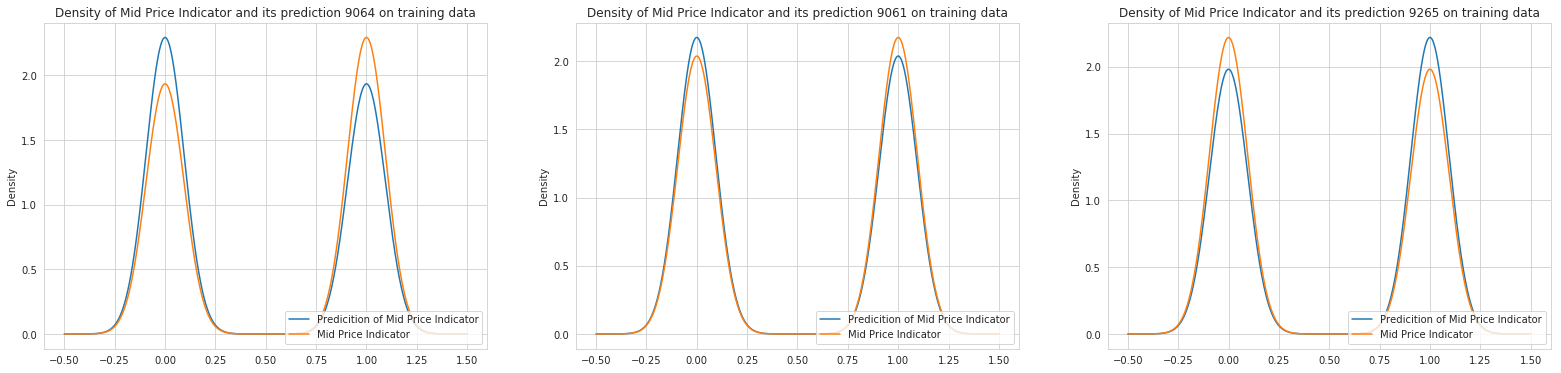

In [14]:
f, ax = plt.subplots(1, 3, figsize=(27,6))
for i in range(len(stocks)):
    s = stocks[i]
    d_stocks[s]['Predicition of Mid Price Indicator'] = d_stocks[s]['pred_log']
    d_stocks[s]['Mid Price Indicator'] = d_stocks[s]['mid_price_indicator']
    d_stocks[s][d_stocks[s]['pred_log'] != d_stocks[s][
        'mid_price_indicator']][['Predicition of Mid Price Indicator', 'Mid Price Indicator']].plot(
        kind='kde', ax=ax[i])
    ax[i].set_title('Density of Mid Price Indicator and its prediction {} on training data'.format(s))
    ax[i].legend(loc='lower right')
plt.savefig('density_of_mid_price_and_prediction_training_data_svm.png')

IndexError: index 0 is out of bounds for axis 0 with size 0

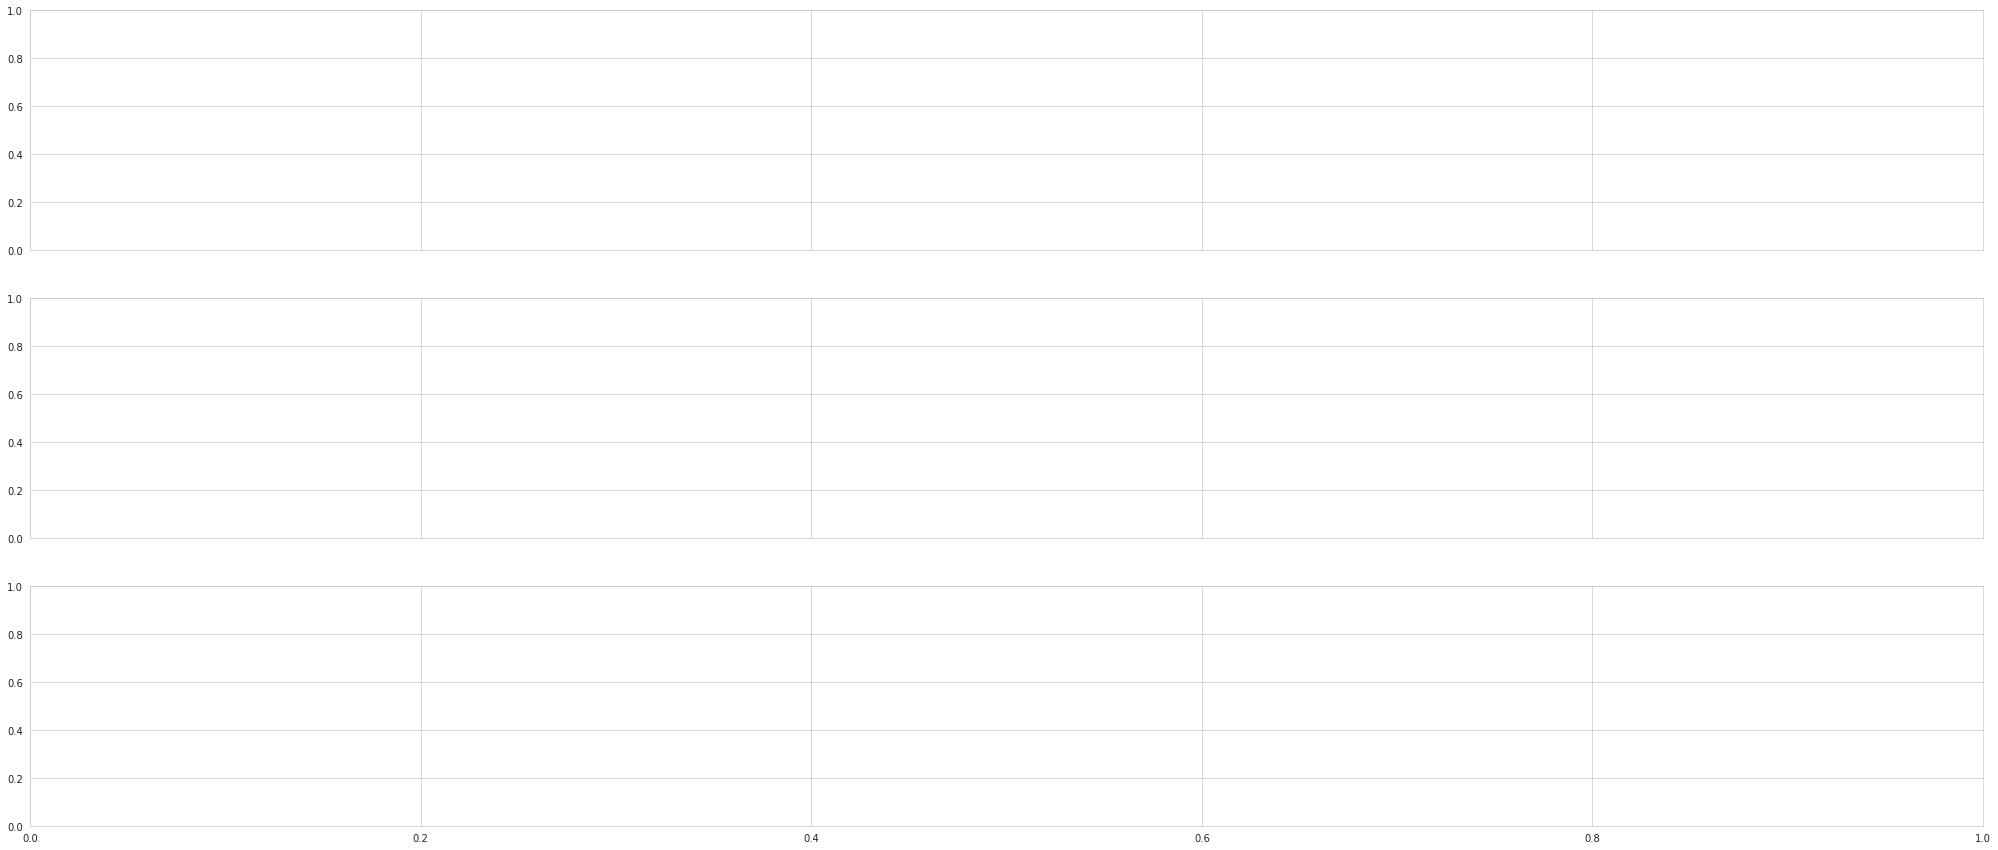

In [15]:
f, ax = plt.subplots(3, 1, figsize=(35, 15), sharex=True)
i = 0

for i in range(len(stocks)):
    s = stocks[i]
    df = d_stocks[s]
    X = d_stocks[s][['queue_imbalance']].values
    y = d_stocks[s]['mid_price_indicator'].values.astype(np.integer)

    clf = fit_best_svm_classifier(df_best_svm, d_stocks[s])
    plot_decision_regions(X[0:900], y[0:900], clf=clf,ax=ax[i],
                         colors=','.join(['orange', 'blue']))
    ax[i].set_xlabel('Queue Imbalance')
    ax[i].set_title('SVM Decision Regions for {} on training data'.format(s))
    ax[i].set_xlim(-1.01, 1.01)
    print(min(df[df['pred_log'] == 1]['queue_imbalance']), max(df[df['pred_log'] == 0]['queue_imbalance']),
        clf.score(X, y))


plt.savefig('svm_decision_region.png')